In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time
#A continuación se importan laas librerias necesarias para el entrenamiento de la red 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import ConvLSTM2D
from keras.layers import Flatten


Using TensorFlow backend.


(210865,)


Text(0.5, 1.0, 'Datos reales')

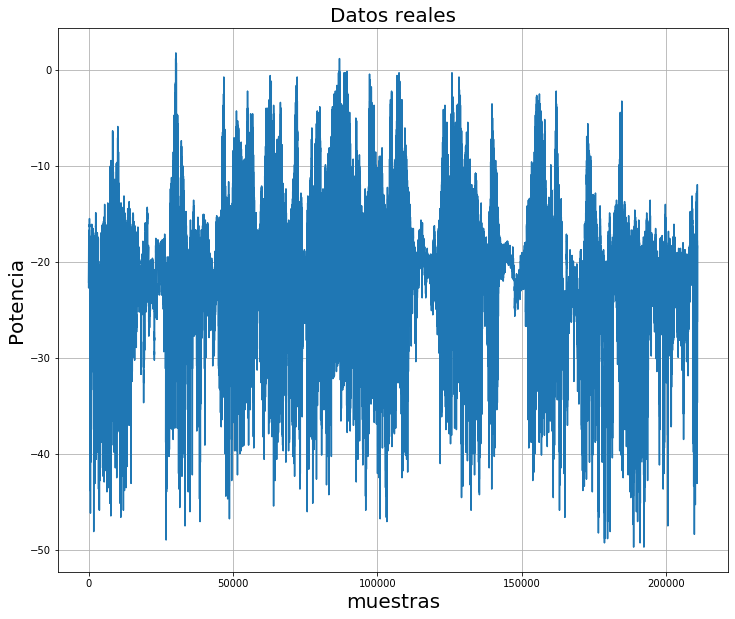

In [3]:
dataframe = pd.read_csv('/content/drive/My Drive/LSTM /Mediciones en csv/LTNLOS CSV/potencia 2000-01-30 20_3A45_3A47 Antenna Horn Time 300[s] SwitchingBy 0 Horn 0 Omni 0 FIN_010.csv', header=None )
#llevar al dataframe a un arreglo de valores
dataset = dataframe.values
#dataset solo para la funcion senoidal
POT = dataset[0:len(dataset),1]
#POT = dataset
print(POT.shape)
plt.figure(figsize=[12,10])
plt.grid()
plt.plot(POT)
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.title("Datos reales", fontsize = 20)

# Nueva sección

In [4]:
#llevo la funcion a un arreglo de [lARGO DEL ARREGLO ,1] PARA ESCALAR LOS DATOS y que la red aprenda de mejor forma
POT2=POT.reshape(len(POT),1)
print(POT2.shape)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
POT2 = scaler.fit_transform(POT2)

(210865, 1)


In [5]:
# divido la funcion y1 en arreglos para entrenar y probar la red
train_size = int(len(POT2) * 0.8)
test_size = len(POT2) - train_size
train, test = POT2[0:train_size,:], POT2[train_size:len(POT2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

168692 42173
(168692, 1)
(42173, 1)


In [0]:
# convertir un arreglo de valores en una matrix
def create_dataset(POT2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(POT2)-look_back-1):
        a = POT2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(POT2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [7]:
# reshape dentro X=t and Y=t+1
look_back = 128
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
#print(trainX[0])
#print(trainY[0])
#print(trainX[1])
#print(trainY[1])
#print(trainX[2])
#print(trainY[3])

(168563, 128)
(42044, 128)
(168563,)
(42044,)


In [8]:
# reshape a la entrada [samples, time steps, features] que es necesario para la red lstm
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape)
print(testX.shape)

(168563, 128, 1)
(42044, 128, 1)


In [0]:
neuronas= 100





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


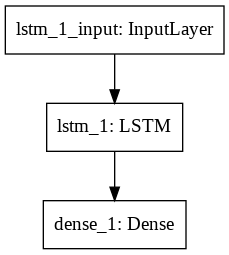

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(neuronas, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()
keras.utils.plot_model(model, 'my_first_model.png')

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
filepath="Checkpoint_mejores_pesos.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_absolute_percentage_error', verbose=1, save_best_only=True, mode='min')
# simple early stopping
es = EarlyStopping(monitor='val_mean_absolute_percentage_error', mode='min', verbose=1, patience=3)

In [12]:
batch_size= 32 
epochs= 10
start = time.time()
History_sen = model.fit(trainX, trainY,batch_size=batch_size, epochs= epochs, callbacks=[es, checkpoint] , validation_split=0.1)
print("> Compilation Time : ", time.time() - start)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 151706 samples, validate on 16857 samples
Epoch 1/10





151706/151706 [==============================] - 861s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 8.5049 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 7.7053

Epoch 00001: val_mean_absolute_percentage_error improved from inf to 7.70528, saving model to Checkpoint_mejores_pesos.hdf5
Epoch 2/10
151706/151706 [==============================] - 868s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 7.7331 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0381 - val_mean_absolute_percentage_error: 7.3370

Epoch 00002: val_mean_absolute_percentage_error improved from 7.70528 to 7.33696,

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_ltnlos_señal2.json", "w") as json_file:
    json_file.write(model_json)


In [0]:
import pickle

pickle_out = open("History_sen.pickle","wb")
pickle.dump(History_sen, pickle_out)
pickle_out.close()

In [0]:
import pickle 

pickle_in = open("History_sen.pickle","rb")
History_saved = pickle.load(pickle_in)


In [0]:
History = History_saved

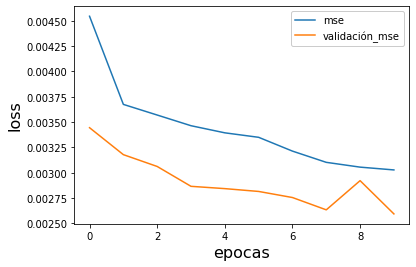

In [17]:
# plot metrics
#plt.figure(figsize=[8,8])
plt.plot(History.history['mean_squared_error'], label='mse')
plt.plot(History.history['val_mean_squared_error'], label= 'validación_mse')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

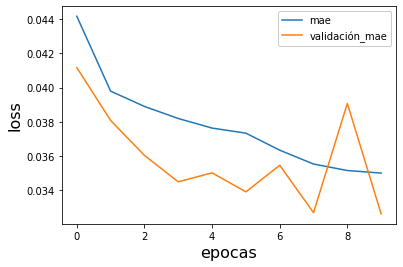

In [18]:
plt.plot(History.history['mean_absolute_error'], label='mae')
plt.plot(History.history['val_mean_absolute_error'], label= 'validación_mae')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [19]:
History.history['mean_absolute_percentage_error']

[8.504924558636736,
 7.733123059147228,
 7.592981171944604,
 7.4698708965307095,
 7.374103344036997,
 7.31686831490611,
 7.126786265261899,
 6.970232024409123,
 6.899134833492142,
 6.869199352827157]

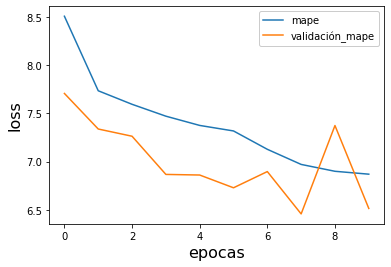

In [20]:
plt.plot(History.history['mean_absolute_percentage_error'], label= 'mape')
plt.plot(History.history['val_mean_absolute_percentage_error'], label= 'validación_mape')
plt.xlabel("epocas",fontsize = 16)
plt.ylabel("loss",fontsize = 16)
plt.legend(framealpha=1, frameon=True)

In [21]:
# predicciones de los valores de prueba
prediccion_test = model.predict(testX)
prediccion_test = scaler.inverse_transform(prediccion_test)
#actuals = test_y
valor_real_test = scaler.inverse_transform([testY])
valor_real_test= valor_real_test.reshape(len(prediccion_test),1)
#prediccion de los valores de entrenamiento
aprendido=model.predict(trainX)
aprendido_train=scaler.inverse_transform(aprendido)
reales_train=scaler.inverse_transform([trainY])
reales_train=scaler.inverse_transform([trainY])
reales_train=reales_train.reshape(len(aprendido),1)
###################################################
mse_aprendido=mean_squared_error(reales_train,aprendido_train)
mse_test=mean_squared_error(valor_real_test,prediccion_test)
print('Train Mean square Error:', mse_aprendido)
print('Test Mean square Error:', mse_test)
#######################################################
rmse_train=math.sqrt(mse_aprendido)
rmse_test=math.sqrt(mse_test)
print('Train Root Mean Squared Error:', rmse_train)
print('Test Root Mean Squared Error:', rmse_test)


Train Mean square Error: 7.874318750865711
Test Mean square Error: 4.408648865059141
Train Root Mean Squared Error: 2.80612165646212
Test Root Mean Squared Error: 2.0996782765602786


In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
#mape train
mean_absolute_percentage_error(reales_train,aprendido_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


inf

In [24]:
#mape test
mean_absolute_percentage_error(valor_real_test,prediccion_test)

5.739166538272877

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [26]:
smape(reales_train,aprendido_train)

9.849170363008948

In [27]:
smape(valor_real_test,prediccion_test)

5.7119058680461645

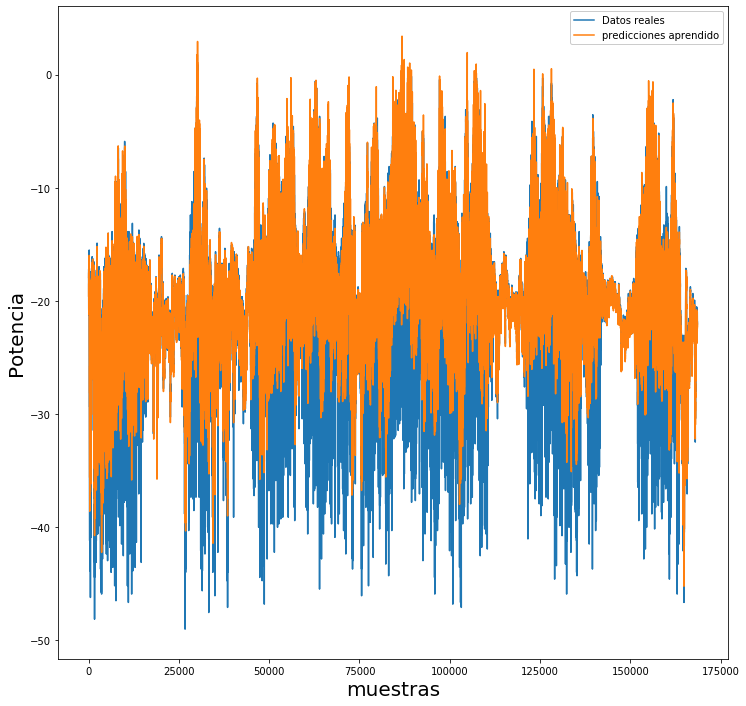

In [28]:
# plot entrenamiento
plt.figure(figsize=[12,12])
plt.plot(reales_train, label='Datos reales')
plt.plot(aprendido_train, label= 'predicciones aprendido')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

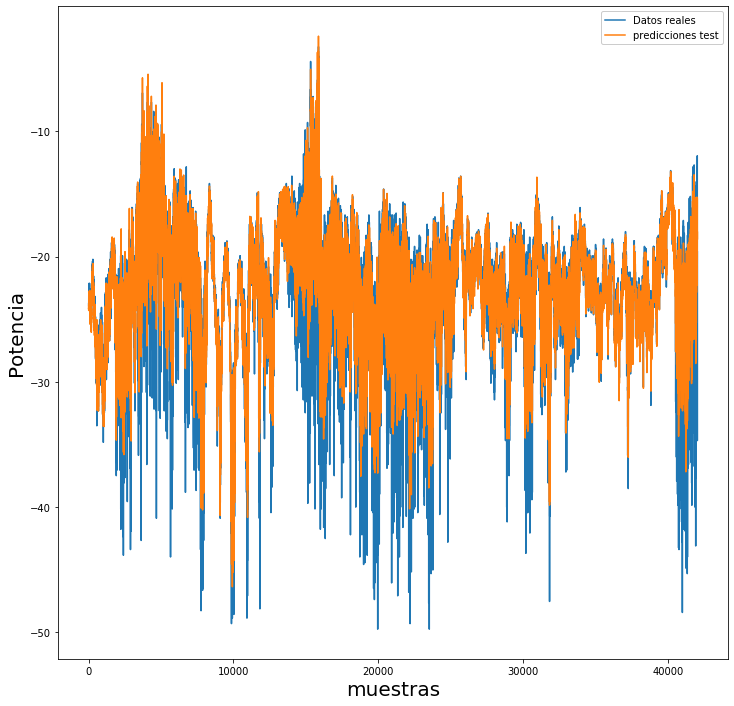

In [29]:
# plot test
plt.figure(figsize=[12,12])
plt.plot(valor_real_test, label='Datos reales')
plt.plot(prediccion_test , label= 'predicciones test')
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.legend(framealpha=1, frameon=True, loc='upper right')

In [30]:
acc = abs(prediccion_test-valor_real_test)
porc_error = (acc / abs(valor_real_test)) * 100
mostrar = valor_real_test, prediccion_test, acc, porc_error
Tabla_arr = np.array(mostrar)
Tabla = np.transpose(Tabla_arr)
Tabla=Tabla.reshape(len(acc), -1)
Tabla_df = pd.DataFrame(Tabla, columns=['Datos predichos','Datos reales','Error','Error porcentual'])
Tabla_df

,Datos predichos,Datos reales,Error,Error porcentual
0,-23.76,-24.147827,0.387827,1.632269
1,-23.47,-24.055403,0.585403,2.494260
2,-23.32,-23.840691,0.520691,2.232807
3,-23.62,-23.856535,0.236535,1.001418
4,-23.76,-24.205004,0.445004,1.872911
...,...,...,...,...
42039,-18.89,-18.108021,0.781979,4.139646
42040,-16.68,-15.767736,0.912264,5.469206
42041,-18.30,-18.003088,0.296912,1.622470
42042,-34.69,-18.642029,16.047971,46.261087


In [0]:
import seaborn as sns

In [0]:
aprendido_red=aprendido_train[:,0]
rial=reales_train[:,0]
testing=valor_real_test[:,0]
prediccion=prediccion_test[:,0]

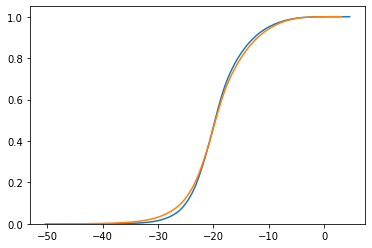

In [33]:
sns.kdeplot(aprendido_red, cumulative=True)
sns.kdeplot(rial, cumulative=True)

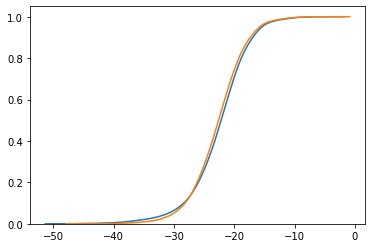

In [34]:
sns.kdeplot(testing, cumulative=True)
sns.kdeplot(prediccion, cumulative=True)

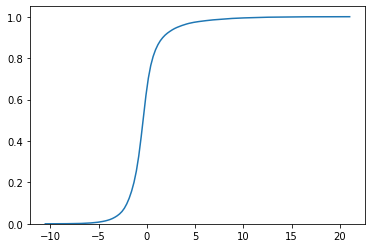

In [35]:
err=prediccion_test-valor_real_test
err_1=err[:,0]
sns.kdeplot(err_1, cumulative=True)